# 基于用户的协同过滤算法

In [1]:
# 导入包
import random
import math
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
from collections import defaultdict

## **获取运行时间**

In [2]:
# 定义装饰器，监控运行时间
def timmer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        res = func(*args, **kwargs)
        stop_time = time.time()
        print('函数 %s, 运行时间: %s' % (func.__name__, stop_time - start_time))
        return res
    return wrapper

## 二维字典的添加

In [3]:
#二维字典的添加
def addtwodimdict(thedict, key_a, key_b, val):
    if key_a in thedict:
        thedict[key_a].update({key_b: val})
    else:
        thedict.update({key_a:{key_b: val}})    


##  数据导入与处理


In [4]:
class Dataset():
    
    def __init__(self, fp, nrows=-1):
        
        # fp: 文件路径
        self.nrows = nrows
        self.data, self.user_set= self.loadData(fp)
    @timmer
    def loadData(self,fp="data/ml-1m/ratings.dat"):
        data = []
        user_set=set()
        item_set=set()

        for l in open(fp):
            temp=list(map(int,l.strip().split('::')))
            data.append(temp)
            user_set.add(temp[0])
            item_set.add(temp[1])
        data=list(sorted(data,key=lambda x:x[3]))

        return data,user_set
    
    @timmer
    def dealData(self,data):      
        train = []
        le=len(data)
        rating_dict={}
        for user, item, rating, timestamp in self.data:
            addtwodimdict(rating_dict, user, item, rating)
            
        for user, item, rating, timestamp in data:
            train.append((user, item))
                
        # 处理成字典的形式，user->set(items)
        def convert_dict(data):
            data_dict = {}
            for user, item in data:
                if user not in data_dict:
                    data_dict[user] = set()
                data_dict[user].add(item)
            #data_dict = {k: list(data_dict[k]) for k in data_dict}
            return data_dict

        return convert_dict(train), rating_dict, 
        


## 基于用户余弦相似度的推荐(多个用户推荐）


In [5]:

def UserCF(train, rating_dict, K, N):
    '''
    :params: train, 训练数据集
    :params: rating_dict, 用户电影评分
    :params: K, 超参数，设置取TopK相似用户数目
    :params: N, 超参数，设置取TopN推荐物品数目
    :return: GetRecommendation, 推荐接口函数
    '''
    # 计算item->user的倒排索引
    item_users = {}
    for user in train:
        for item in train[user]:
            if item not in item_users:
                item_users[item] = []
            item_users[item].append(user)
    
    # 计算用户相似度矩阵
    sim = {}
    num = {}
    for item in item_users:
        users = item_users[item]
        for i in range(len(users)):
            u = users[i]
            if u not in num:
                num[u] = 0
            num[u] += 1
            if u not in sim:
                sim[u] = {}
            for j in range(len(users)):
                if j == i: continue
                v = users[j]
                if v not in sim[u]:
                    sim[u][v] = 0
                sim[u][v] += 1
    for u in sim:
        for v in sim[u]:
            sim[u][v] /= math.sqrt(num[u] * num[v])
    
    # 按照相似度排序
    sorted_user_sim = {k: list(sorted(v.items(), \
                               key=lambda x: x[1], reverse=True)) \
                       for k, v in sim.items()}
    
    # 获取接口函数
    def GetRecommendation(user):
        items = {}
        
        seen_items = set(train[user])
        for u, _ in sorted_user_sim[user][:K]:
            for item in train[u]:
                # 要去掉用户见过的
                if item not in seen_items:
                    if item not in items:
                        items[item] = 0
                    items[item] += sim[user][u]*rating_dict[u][item]
        
        recs = list(sorted(items.items(), key=lambda x: x[1], reverse=True))[:N]
        return recs
    
    return GetRecommendation

## 基于用户余弦相似度的推荐(单个用户推荐）

In [6]:

def UserCF1(train, rating_dict, user, K, N):
    user_seen=defaultdict(int)
    num=defaultdict(int)
    sim=defaultdict(int)
    
    for item in train[user]:
        user_seen[item]=1
        num[user]+=1 
        
    for v in train:
        if v!=user:
            for item in train[v]:
                num[v]+=1
     
                if user_seen[item]==1:
                    sim[v]+=1
                
    for v in sim:
        sim[v] /= math.sqrt(num[user] * num[v])
    
    # 按照相似度排序
    sorted_user_sim = sorted(sim.items(), key=lambda x: x[1], reverse=True)

    items=defaultdict(int)
    for u, _ in sorted_user_sim[:K]:
        for item in train[u]:
            if user_seen[item]==0:
                items[item] += sim[u]*rating_dict[u][item]
                
                
    recs = list(sorted(items.items(), key=lambda x: x[1], reverse=True))[:N]
    return train, rating_dict, sim, num, recs

## 基于用户余弦相似度的推荐(单个用户推荐）添加函数

In [7]:
def AddUserCF1(train,  rating_dict, user, K, N,sim, num, temp):
    userId=temp[0]
    itemId=temp[1]
    rating=temp[2]
    
    if userId not in train:
        train[userId]=set()
        
    train[userId].add(itemId)
    num[itemId]+=1
 
       
    user_seen=defaultdict(int)
    for item in train[user]:
        user_seen[item]=1
    

    if userId!=user:
        sim[userId]+=1
        if num[user]!=0:
            sim[userId] /= math.sqrt(num[user] * num[userId])            
    
    # 按照相似度排序
    sorted_user_sim = sorted(sim.items(), key=lambda x: x[1], reverse=True)
    
    addtwodimdict(rating_dict,userId,itemId,rating)
    
    items=defaultdict(int)
    for u, _ in sorted_user_sim[:K]:
        for item in train[u]:
            if user_seen[item]==0:
                items[item] += sim[u]*rating_dict[u][item]
                
                
    recs = list(sorted(items.items(), key=lambda x: x[1], reverse=True))[:N]
    return train, rating_dict, sim, num, recs

## 运行函数

In [8]:
fp="data_deal/ml-1m/ratings.dat"
dataset1 = Dataset(fp)
#T=1000


函数 loadData, 运行时间: 3.608724355697632


In [9]:
import math
def count_entropy(item,n):
    
    summ=0
    for key,val in item.items():
        summ+=-(val/n)*math.log(val/n)
    return summ
def add_movie(item,idd):
    if idd in item:
        item[idd]+=1
    else:
        item[idd]=1
    return item
    
    

In [10]:
item={}
def get_id(idd,all_data):
    item_set=set()
    fp="data_deal/best_clusterid.csv"
    for l in open(fp):
        temp=list(map(int,l.strip().split(',')))
        if temp[1]==idd:
            item_set.add(temp[0]+1)
    data=[]
    for row in all_data:
        if row[1] in item_set:
            data.append(row)
    return data
    

In [11]:

data=get_id(3,dataset1.data)




In [12]:
entropy=[]
i=0
for it in data:
    add_movie(item,it[1])
    
print(len(data))  

377570


In [13]:
train, rating_dict = dataset1.dealData(data)

函数 dealData, 运行时间: 1.151918888092041


In [14]:
for key,val in train.items():
    print(type(val))

<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class

<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class 'set'>
<class

In [15]:
K, N=100, 10
user=2
train, rating_dict, sim, num, recs=UserCF1(train, rating_dict, user, K, N)
print("为用户{}推荐的电影：".format(user))
for it in recs:
    print(it)

为用户2推荐的电影：
(1580, 118.31602161170532)
(733, 112.81354972611778)
(1573, 90.13467063399563)
(1722, 82.42201232205565)
(2763, 79.77417588209995)
(2058, 79.09870759459247)
(1918, 76.12232263007326)
(316, 73.86731748084712)
(1876, 67.75509085010009)
(2617, 66.43887001362059)


In [15]:
# item={}
# item=add_movie(item,recs[0][0])
# i=1
# entropy=[]
# print(count_entropy(item,i))
# entropy.append(count_entropy(item,i))

In [16]:
summ=0
for key,val in item.items():
    summ+=val

print(count_entropy(item,len(data)))
entropy.append(count_entropy(item,len(data)))
item=add_movie(item,recs[0][0])
i=len(data)+1
print(count_entropy(item,i))
entropy.append(count_entropy(item,i))

6.780180772477611
6.78017606343798


In [17]:
user_list=[]
for key,val in train.items():
    user_list.append(key)
print(len(user_list))
print(len(train))

6031
6031


In [18]:

K, N=100, 10
user=2
numm=1000
x=0
ch=sorted([random.randint(0,len(train)-1) for _ in range(10)])
while 1==1:
    x+=1
    u=0
    
    for idd in ch:
        
        if len(recs)!=0:
            temp=[user,recs[0][0],5.0]
            train, rating_dict, sim, num, recs=AddUserCF1(train, rating_dict, user_list[idd], K, N, sim, num,temp)
        
        if recs==[]:
            continue    

        if recs[0][0] in item:
            item[recs[0][0]]+=1
        else:
            item[recs[0][0]]=1
        i+=1
        entropy.append(count_entropy(item,i))
    if x==numm:
        break
    #print(count_entropy(item,i))
    
                
    #temp=[dataset.data[i][0],dataset.data[i][1],dataset.data[i][2]]
    #train, rating_dict, sim, num, recs=AddUserCF1(train, rating_dict, user, K, N, sim, num,temp)


    


[6.780180772477611, 6.78017606343798, 6.780173045579708, 6.780170927200646, 6.780166217202454]


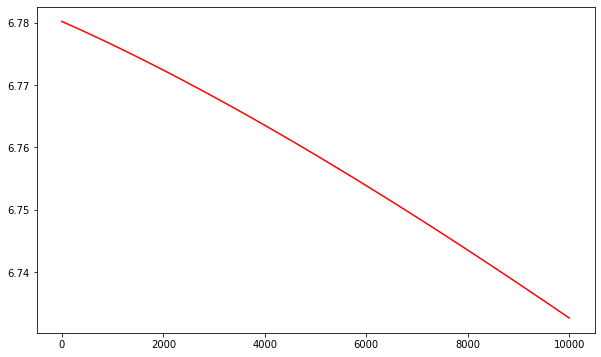

In [19]:
print(entropy[:5])
import matplotlib.pyplot as plt
%matplotlib inline
x=[i for i in range(0,len(entropy))]
fig = plt.figure(figsize=(10,6))
plt.plot(x,entropy,color='red')
plt.show()



In [20]:
import pandas as pd
test=pd.DataFrame(data=entropy)
test.to_csv('entropy.csv')

In [21]:
data=get_id(0,dataset1.data)

In [20]:

for it in data:
    item=add_movie(item,int(it[1]))
    i+=1
    entropy.append(count_entropy(item,i))
    



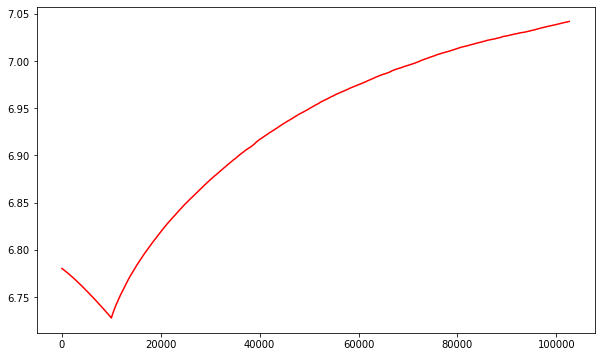

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
x=[i for i in range(0,len(entropy))]
fig = plt.figure(figsize=(10,6))
plt.plot(x,entropy,color='red')
plt.show()


In [22]:
print(len(data))


92625


In [23]:
train[0]=set()
train[0].add(1)
for it in data:
    temp=[it[0],it[1],it[2]]
    train, rating_dict, sim, num, recs=AddUserCF1(train, rating_dict, 0, K, N, sim, num,temp)


In [26]:
user_list=[]
for key,val in train.items():
    user_list.append(key) 

In [24]:

K, N=100, 10
numm=1000
x=0

while 1==1:
    x+=1
    u=0
    #ch=sorted([random.randint(0,len(train)-1) for _ in range(10)])
    for idd in ch:
        
        if len(recs)!=0:
            temp=[user,recs[0][0],5.0]
            train, rating_dict, sim, num, recs=AddUserCF1(train, rating_dict, user_list[idd], K, N, sim, num,temp)
        
        if recs==[]:
            continue    

        if recs[0][0] in item:
            item[recs[0][0]]+=1
        else:
            item[recs[0][0]]=1
        i+=1
        entropy.append(count_entropy(item,i))
    if x==numm:
        break    

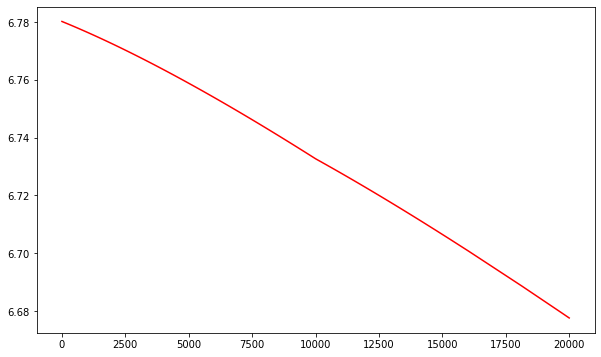

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
x=[i for i in range(0,len(entropy))]
fig = plt.figure(figsize=(10,6))
plt.plot(x,entropy,color='red')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
x=[i for i in range(0,len(norm))]
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
plt.plot(x,norm,color='red')

norm_cha=[norm[i]-norm[i-1] for i in range(1,len(norm))]
ax4 = fig.add_subplot(1,2,2)

plt.plot(x[:-1],norm_cha,color='red')

plt.show()

In [ ]:
import pandas as pd
test=pd.DataFrame(data=norm)
test.to_csv('norm.csv')
test=pd.DataFrame(data=result)
test.to_csv('result.csv')